# Section 4: Recognising written digits with the MNIST dataset


## Video 1: downloading the data, and visualising it
The MNIST database (Modified National Institute of Standards and Technology database) consists of labeled images of written digits. Each image is a grayscale image which is normalized to fit into a 20x20 pixel bounding box, and anti-aliased. The MNIST database is a derivative of the NIST dataset, and contains 60,000 training images and 10,000 testing images

The MNIST dataset is used very often in projects, as it is a great practical example to test your network on. New novel network architectures often show how well they perform on the MNIST dataset. Even if your new network architecture does not perform better, it's often easy to show interesting features using the MNIST dataset. As it's used very often, loading the MNIST dataset is included in your installation of Tensorflow. 

Execute the following code will either load the data, and if it's your first time loading the data it will download the data. 


In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("datasets/MNIST_data/", one_hot=True)


Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


### Visualising MNIST
Just like the previous sections I think it's important to know how our data is represented. In this case we see that we are dealing with a `Datasets` object, and that we can get a batch of images and labels from this object:

In [2]:
images, labels = mnist.train.next_batch(5)
print(len(images[0]))


784


### Plotting the images
One important thing to know is that one digit is a long array. In this case we can use NumPy to reshape our data to visualise it with Matplotlib. 

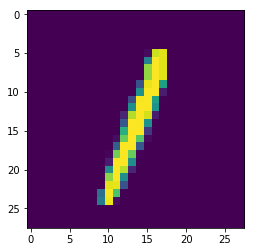

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


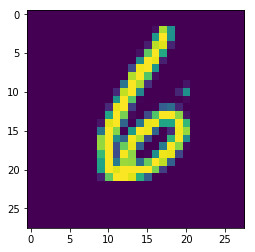

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


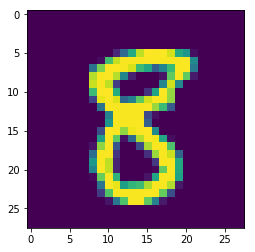

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


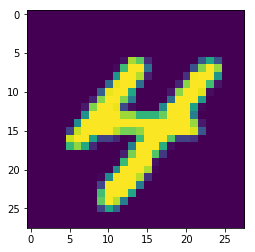

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


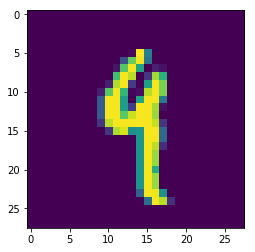

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


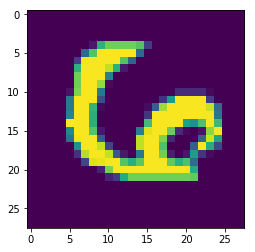

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


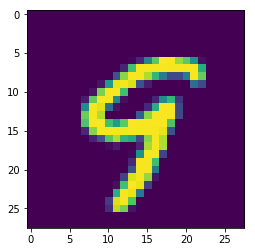

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


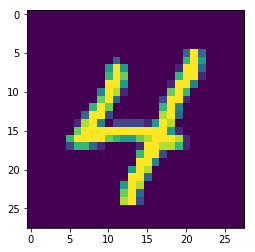

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


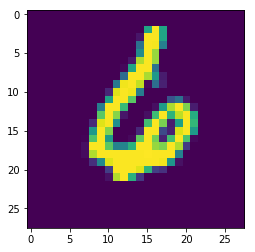

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


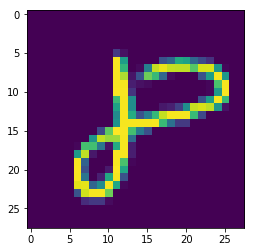

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
images, labels = mnist.train.next_batch(10)
for image, label in zip(images, labels):
    image_reshaped = np.reshape(image, (28,28))
    
    plt.imshow(image_reshaped)
    plt.show()
    print(label)

### Nicer visualisations and difficult data
If you want to see all digits in a multi-dimensional space you can take a look at this [blogpost](http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/) I made about using Tensorboard and the MNIST digits. Another interesting link you can try is the [notmnist dataset](http://yaroslavvb.blogspot.nl/2011/09/notmnist-dataset.html) which consists of alphabetical characters in several funky fonts:
![not mnist](http://yaroslavvb.com/upload/notMNIST/nmn.png)

## Video 2: Dense layer approach
In the previous videos we only used dense layers to make predictions. Let's do this again, but this time for image recognition and see what score we get. 
Note that we keep using the mean squared error as loss function, and the gradient descent optimizer. We will quickly introduce a better function to replace it. 

In [4]:
LEARNING_RATE = 0.05
ACTIVATION_FUNCTION = tf.nn.relu
INPUT_UNITS = 28*28
OUTPUT_UNITS = 10

tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32, [None, INPUT_UNITS], name="x_placeholder")
y_placeholder = tf.placeholder(tf.float32, [None, OUTPUT_UNITS], name="y_placeholder")

hiddenlayer = tf.layers.dense(inputs=x_placeholder, units=400, activation=ACTIVATION_FUNCTION, name="hidden_layer")
predicted_class = tf.layers.dense(inputs=hiddenlayer, units=OUTPUT_UNITS, activation=ACTIVATION_FUNCTION, name="prediction")

loss = tf.losses.mean_squared_error(y_placeholder,predicted_class)
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

In [5]:
init = tf.global_variables_initializer() # https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer
sess = tf.InteractiveSession() # https://www.tensorflow.org/api_docs/python/tf/Session
sess.run(init)

In [6]:
BATCH_SIZE = 128
ITERATIONS = 1000
losses = list()
for _ in range(ITERATIONS):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    opt_res, current_loss = sess.run([optimizer, loss], 
                                     feed_dict={x_placeholder: batch_xs, 
                                                y_placeholder: batch_ys})
    losses.append(current_loss)


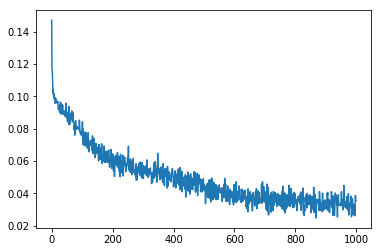

In [7]:
plt.plot(losses)

In [8]:
def get_accuracy(dataset, 
                 inputtensor, 
                 outputtensor, 
                 session, 
                 test_size=1000,
                 batch_size=32):
    correct_predictions = 0
    total_tested = 0
    for _ in range(int(test_size/batch_size)):
        total_tested += batch_size
        
        batch_xs, batch_ys = dataset.next_batch(batch_size)
        predicted_chars = session.run(outputtensor, 
                                      feed_dict={inputtensor: batch_xs})
        for truechar, predictedchar in zip(batch_ys, predicted_chars):
            if np.argmax(truechar) == np.argmax(predictedchar):
                correct_predictions += 1
    
    return correct_predictions/total_tested

accuracy = get_accuracy(mnist.test, x_placeholder, predicted_class, sess)
print("Accuracy: " + str(accuracy))

Accuracy: 0.7933467741935484


### Comparing to state of the art
Although what we have right now seems pretty good, it's important to take a look at what the state of the art is doing: http://rodrigob.github.io/are_we_there_yet/build/

As you can see we should not be happy with our results, and continue learning to improve our network. 
![mnist results](illustrations/mnistresults.png)


## Video 3: convolution and max-pooling layers

![image](illustrations/six_three.png)
Imagine you are trying to recognize the center image above. You will probably see that this is a six, and the two images next to it are also sixes... For our neural network we made above these are completely different inputs!
What you have to know about the human brain is that there are multiple layers of vision. The "lower" layers recognise simple features, like lines. Higher layers take these lower features as input and make higher level features out of it. 

Neural networks can learn this as well! A big reason neural networks are so popular nowadays is the **convolutional layer**. A convolutional layer is a trainable **feature detector**. It activates when it detects a certain pattern. We slide multiple feature detectors over the image and record the result in a new layer. 

To understand this: let's start with a MNIST image:

![image](illustrations/six1.png)

There are some features we are probably interested in, like horizontal or vertical lines: 

![image](illustrations/activations_first_conv_layer.png)


In our next layer we create ** Feature layers ** by **convolving ** a block with ** filters ** over our image. Note that in our neural network we don't define these filters ourselves, the network has to learn them itself. After this **convolution** layer we end up with a new matrix. Instead of the R,G,B dimension we would have in a colour image, we have dimensions that have the activation to a certain filter...

![image](illustrations/Convsmalltomany.jpg)

What you need to know is that you can represent these weights as a block: one set of weights is `[width, height, in_dimension, out_dimension]`. It is as if you make a small neural network that takes part of your image as input, and gives X features as output. Luckily we don't have to define these weights and computations ourselves. To save time and make easier to read code we will use the `tf.layers.conv2d` function. 

This function slides a network over the image, and puts the result in a feature map. Here is a visualisation of what roughly happens:
![image](illustrations/Convolutiondrawing.jpg)

There are some terms you need to know. If you look at the signature of the `tf.layers.conv2d` function you will see that it takes the following arguments:

#### Kernel size
The kernel size is the width and height of a single filter. Often a kernel size of 3x3 or 5x5 is chosen for classification problems. The larger the filter the more information it takes in, but it also makes your program slower and it generalises less. 
![image](illustrations/kernelsize.jpg)

Note that you can even take a 1x1 convolution. In that case you are simply doing a dimensionality reduction: you try to train a neural network that can take X features (for example: 64), and represent them in Y features (for example: 32), preferably without losing a lot of information. 

#### Padding
Let's say your kernel is 3x3 and your image is 5x5: there are two ways you can convolve over this image:

##### Padding: valid
You convolve over the parts that are actually visible to the detector. As output you get a feature map with a smaller width and height (in our example: result would be 4x4), because you can't slide over the edges:
![image](illustrations/valid.jpg)

##### Padding: same
You can also choose to "pad" the input with zeroes around the edges. This way you get an activation for the edges, although it's a bit distorted thanks to the padding. The output of your convolution is a feature map with the SAME width and height as your input convolution map. In our example, the width and height of the output would be 4x4. 

![image](illustrations/same.jpg)




#### Strides
You can look at every part of the image by sliding your detector over the image and shifting 1 pixel in the x direction and/or 1 pixel in the y direction. You could also choose to skip pixels, this would still give you an activation at many parts of the image, but results in a smaller output. Below I show the output for two possible strides:

![image](illustrations/Strides.jpg)






### Pooling
The convolution layer provides a lot of information. It's also an operation that creates very big data structures. You can reduce the output of your convolutional layers by taking larger strides, but this way you might miss a very important feature (you skip over it). Pooling tries to solve this problem: on many points on the feature map you take combine activations in the neighbourhood.

There are two popular pooling methods: max pooling and average pooling. 

#### Max pooling
In max pooling we select the "pixels" with the highest activation in every group. Often this grouping is done in a 2x2 grid, and results in one number. This means that your data after a pooling operation is 4x smaller than before!

![max pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

We can use the Tensorflow layers function to perform our max pooling operation. If you look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d) you see that it requires some arguments you hopefully are familiar with right now:
- Pool size: this is the same idea as the kernel size in convolution
- Strides: the same as kernel size in convolution.

We will use a pool size of (2,2) and a stride of (2,2). This results in the same effect as you see in the image above. 

#### Average pooling
Instead of taxing the maximum value you take the average value of the values you are pooling. We are not using this 


## Put it in code! Convolution and max pooling layers

In [9]:
tf.reset_default_graph()

x_placeholder = tf.placeholder(tf.float32, shape=[None, 784])
y_placeholder = tf.placeholder(tf.float32, shape=[None, 10])

In [10]:
x_image = tf.reshape(x_placeholder, [-1, 28, 28, 1])
FIRST_LAYER_KERNEL_SIZE = 5
SECOND_LAYER_KERNEL_SIZE = 3

conv_layer1 = tf.layers.conv2d(x_image,
                              32,
                              (FIRST_LAYER_KERNEL_SIZE, FIRST_LAYER_KERNEL_SIZE),
                              activation=tf.nn.relu,
                              padding='same')
pool_layer1 = tf.layers.max_pooling2d(conv_layer1,
                                     (2,2),
                                     (2,2),
                                     padding='same')


conv_layer2 = tf.layers.conv2d(pool_layer1, 
                               64, 
                               (SECOND_LAYER_KERNEL_SIZE,SECOND_LAYER_KERNEL_SIZE), 
                               activation = tf.nn.relu, 
                               padding='same')
pool_layer2 = tf.layers.max_pooling2d(conv_layer2,
                                      (2,2),
                                      (2,2),
                                      padding='SAME')

flattened = tf.contrib.layers.flatten(pool_layer2)
hidden_fully_connected_layer = tf.layers.dense(inputs=flattened, units=1024, activation=tf.nn.relu)
y_conv = tf.layers.dense(inputs=hidden_fully_connected_layer, units=10, activation=None)

In [11]:
loss = tf.losses.mean_squared_error(y_placeholder, y_conv)
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

Iteration 0, loss: 0.102472, accuracy: 0.104167
Iteration 100, loss: 0.076560, accuracy: 0.666667
Iteration 200, loss: 0.054556, accuracy: 0.781250
Iteration 300, loss: 0.045374, accuracy: 0.802083
Iteration 400, loss: 0.042165, accuracy: 0.885417
Iteration 500, loss: 0.031244, accuracy: 0.916667
Iteration 600, loss: 0.036819, accuracy: 0.875000
Iteration 700, loss: 0.028893, accuracy: 0.947917
Iteration 800, loss: 0.027128, accuracy: 0.937500
Iteration 900, loss: 0.026144, accuracy: 0.885417
Final performance: accuracy: 0.937200


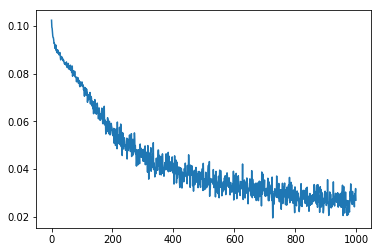

In [12]:
BATCH_SIZE = 64
ITERATIONS = 1000
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

losses = list()
for iteration in range(ITERATIONS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    _, l = sess.run([train_step, loss], feed_dict={x_placeholder: batch[0], y_placeholder: batch[1]})
    losses.append(l)
    
    ## Added: every 100 steps print the accuracy!
    if iteration % 100 == 0:
        accuracy = get_accuracy(mnist.test, x_placeholder, y_conv, sess, test_size=100)
        print("Iteration %d, loss: %f, accuracy: %f" % (iteration, l, accuracy))
        
accuracy = get_accuracy(mnist.test, x_placeholder, y_conv, sess, test_size=10000)
print("Final performance: accuracy: %f" % (accuracy))
plt.plot(losses)


### Putting convolutional operations in your neural network
We now saw how we could improve our performance on the MNIST task with convolutional and pooling layers! 

Depending on the task you are trying to solve. In classification problems you often:
- Take the data as input
- Represent it as an image with shape [batch_size, width, height, dimensions]
- Do a convolution with activation function
- Do a pooling layer
- Repeat convolution + pooling layers for as long as you want
- Reshape it 
- Add (some) dense layers



## Video 4: from activations to probabilities: the softmax function
Note that if we currently get the output of our MNIST detection network we get an activation. Often people on StackOverflow ask how they get a "certainty", or "probability" estimate for each class. 

A function that provides a probability distribution over our classes is the [**softmax function**](https://en.wikipedia.org/wiki/Softmax_function). It takes the activations as input, and for each activation it divides $e^{activation}$ by the sum of each $e^{activation}$. It thus looks like this: 

$softmax(activation_j) = \frac{e^{activation_j}}{\sum_i e^{activation_i}}$

Adding the softmax function to our graph is easy:


In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

softmax_output = tf.nn.softmax(y_conv)
smoutput, a_output = sess.run([softmax_output, y_conv], feed_dict={x_placeholder: batch[0]})
print("Activation output: " + str( a_output[0]))
print("Softmax output: " + str(smoutput[0]))

### Properties of the Softmax function
Some important properties of the softmax function you might want to remember are:
- Resulting values sum up to 1
- Weighting of input is nonlinear: large inputs get more weight than small inputs!

Let's take a look at this last property: 

In [ ]:
def softmax(inputs):
    e_x = np.exp(inputs - np.max(inputs))
    return e_x / e_x.sum()
def linear(inputs):
    return inputs / inputs.sum()

example_activation = np.array([1,2,3,4,1,2,3])

print("Softmax: " + str(softmax(example_activation)))
print("Linear: " + str(linear(example_activation)))


## Video 5: optimization and loss functions
Right now we used the mean squared error to determine our loss, and the gradient descent optimization function. Let's first discuss some alternatives to the mean squared error loss function:

### Loss functions
Mean squared error not only gives a penalty for not being certain about the class you want, it also gives a penalty for being "confused" about another class. For many classification problems it turns out that it's a good idea to run a softmax over the outputs, and then only give a penalty for the error in the expected class. 

There are more loss functions in Tensorflow I won't talk about in these videos. This list [can be found here.](https://www.tensorflow.org/api_docs/python/tf/losses) A short article about them can be found on [this site](https://www.tensorflow.org/api_guides/python/contrib.losses)

A great article going deeper into why you want to use softmax cross entropy loss for classification problems can be [found here](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/). 

In the future, remember that if you are dealing with a classification problem it's a good idea to use the cross entropy error (note: perhaps you can revisit the iris dataset in section 2!). 

### Optimization functions
Just like picking a better loss function there are some other optimization functions that can be better than the gradient descent function we used in the previous videos. To understand these optimization function we need to look at the representation of our learning landscape again: 


There are some great articles on optimization algorithms that I can really recommend. This one has a "what should I use approach: https://medium.com/towards-data-science/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
While this article has a more mathematical approach: http://ruder.io/optimizing-gradient-descent/

#### Momentum optimization
For the momentum optimization function you have to imagine that every optimization step we move in the direction of our loss. If we have a simple function this means we find the minimum of our function (provided our learning rate is good). If there are local minimum we could get stuck here. 

An optimization function that tries to deal with local minimas is the **momentum function**. Instead of taking the error and moving in that direction you add weigh this with a momentum variable to adjust the direction you were moving in. 

Compare it to a rolling ball: if it is rolling down with a certain speed and encounters a small hill it can just roll over it. 

![image](illustrations/momentumlearning.jpg)

#### ADAM optimisation 
The ADAM optimization algorithm takes a totally different approach. It uses two important characteristics: 
- We give a learning rate parameter to each weight, and adjust this weight every update. This improves performance on problems with "sparse" gradients, like natural language and computer vision problems.
- These parameters are adapted based on the average of recent magnitudes of the gradients for that weight. This is good for "noisy" data. 

#### Choosing your optimizer

Choosing your optimizer can be a difficult task. Just like choosing the right learning rate can be a big difference (like we saw in section 3), choosing the right optimizer can also give you several percentages increase in performance. In this video we only change the optimizer to the Adam Optimizer, but try out some others!

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_placeholder, logits=y_conv)
loss = tf.reduce_sum(cross_entropy)
train_step_cross_entropy = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
sess.run(tf.global_variables_initializer())

losses = list()
for iteration in range(ITERATIONS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    _, l = sess.run([train_step_cross_entropy, loss], 
                    feed_dict={x_placeholder: batch[0], 
                               y_placeholder: batch[1]})
    losses.append(l)
    
    ## Added: every 100 steps print the accuracy!
    if iteration % 100 == 0:
        accuracy = get_accuracy(mnist.test, x_placeholder, y_conv, sess, test_size=100)
        print("Iteration %d, loss: %f, accuracy: %f" % (iteration, l, accuracy))
        
accuracy = get_accuracy(mnist.test, x_placeholder, y_conv, sess, test_size=10000)
print("Final performance: accuracy: %f" % (accuracy))
plt.plot(losses)

## Conclusion
In this section we took on the challenge of recognising digits. We started with knowledge we already had (a deep neural network with dense layers), but learned that using convolution and pooling layers we got a better result. We also learned that using a different loss function and different optimization algorithm improved our accuracy with a few percent. 

With this knowledge we are ready for a big and difficult final project: recognize properties in human faces!

# END 
# END 
# END 
# END # END # END 
# END 
# END 
# END 
v
# END 
# END 
# END 


## Video 4: from activations to probabilities: the softmax function
A question I find way too often on Stackoverflow is how people can go from an activation in their final layer to a probability that the network is "correct". Imagine the network gives you the following activation: `[0.1, 0.3, 0.9, 0.4]`. We probably want guess the network predicted the 3rd class. There are several methods to 'normalize' this outcome. A popular way to do this with neural networks is the [softmax function, or 'normalized exponential function'](https://en.wikipedia.org/wiki/Softmax_function).

The softmax function is: $Softmax(vector_i) \frac{e^{vector_i}}{\sum_j e^{vector_j} }$
The softmax function is a great nonregularity to add to on the final layer of our neural network. 

If you are wondering why in particular the softmax function is such a good function, take a look at the [following Stackoverflow answer](https://stackoverflow.com/questions/17187507/why-use-softmax-as-opposed-to-standard-normalization). 




## Section 5: Understanding and adding convolutional layers and comparing our performance to state of the art. 

In [ ]:
tf.layers?


In [ ]:


tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32, [None, INPUT_UNITS], name="x_placeholder")
y_placeholder = tf.placeholder(tf.float32, [None, OUTPUT_UNITS], name="y_placeholder")


reshaped1 = tf.reshape(x_placeholder, shape=[-1,28,28,1])
conv1 = tf.layers.conv2d(reshaped1, 30, (5,5), strides=(2, 2), activation=tf.nn.relu)
conv2 = tf.layers.conv2d(conv1, 30, (3,3), strides=(1, 1), activation=tf.nn.relu)
print(conv2)
flattened = tf.contrib.layers.flatten(conv2)

hiddenlayer = tf.layers.dense(inputs=flattened, units=400, activation=ACTIVATION_FUNCTION, name="hidden_layer")
predicted_class = tf.layers.dense(inputs=hiddenlayer, units=OUTPUT_UNITS, activation=ACTIVATION_FUNCTION, name="prediction")


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_placeholder, logits=predicted_class))
adamoptimizer = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
# sgdoptimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)



In [ ]:
init = tf.global_variables_initializer() # https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer
sess = tf.Session() # https://www.tensorflow.org/api_docs/python/tf/Session
sess.run(init)

In [ ]:
losses = list()
for _ in range(ITERATIONS):
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    opt_res, current_loss = sess.run([adamoptimizer, cross_entropy], feed_dict={x_placeholder: batch_xs, y_placeholder: batch_ys})
    losses.append(current_loss)
plt.plot(losses)


In [ ]:
accuracies = list()
for _ in range(10):
    accuracy = get_accuracy(mnist.test, x_placeholder, predicted_class, test_size=100)
    print(accuracy)
    accuracies.append(accuracy)
print("Accuracy: " + str(sum(accuracies)/len(accuracies)))

Now there is one thing you should know about how we go over the image with this type of network. We can either apply this filter at every point of the image. This would of course give us the best results, but would result in a very big map in the next layer. It's often good enough to apply this filter at multiple points in the image. This is called the **stride**. 

Another thing you need to know is that if you apply these filters on an image you could apply them only on the real part of the image. You can also say: "I'm still applying my filter on the edges and fill the edges with something random or black". This is called the **padding**. There are two modes for padding: 
- Valid: we don't apply our convolutional filter on the sides of our image
- Same: we do apply our convolutional filter on the sides of the image. If we have stride 1-1 we get the same output in the next layer. 

Now let's apply our filter on an input image. 

One thing we can easily change is the activation function of our network. In [this paper]( https://arxiv.org/abs/1502.01852) authors attempt to solve a more difficult problem: imagenet. In this competition you see many images, and you have to guess what's in the image. To improve upon the state of the art they compare several activation functions. 

## My aantekeningen


In [ ]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.Session()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])
FIRST_LAYER_SIZE = 10
h_conv1 = tf.layers.conv2d(x_image, 32, (FIRST_LAYER_SIZE,FIRST_LAYER_SIZE), activation=tf.nn.relu, padding='same')
h_pool1 = tf.layers.max_pooling2d(h_conv1,(2,2),(2,2),padding='SAME')

h_conv2 = tf.layers.conv2d(h_pool1, 64, (5,5), activation = tf.nn.relu, padding='same')
h_pool2 = tf.layers.max_pooling2d(h_conv2,(2,2),(2,2),padding='SAME')

h_pool2_flat = tf.contrib.layers.flatten(h_pool2)
h_fc1 = tf.layers.dense(inputs=h_pool2_flat, units=1024, activation=tf.nn.relu)
y_conv = tf.layers.dense(inputs=h_fc1, units=10, activation=None)


#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
#train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### OPTION 1: 
### Na 500 iter: 0.916567
### Na 1000 iter: 0.932292
# loss = tf.losses.mean_squared_error(y_, y_conv)
# train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

### OPTION 2: 
### Na 500 iter: 0.960537
### Na 1000 iter: 0.970954
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


BATCH_SIZE = 64
ITERATIONS = 1000

sess.run(tf.global_variables_initializer())
for iteration in range(ITERATIONS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1]})

    if iteration % 100 == 0:
        accuracy = get_accuracy(mnist.test, x, y_conv, sess, test_size=100)
        print("Iteration %d, accuracy: %f" % (iteration, accuracy))
accuracy = get_accuracy(mnist.test, x, y_conv, sess, test_size=10000)
print("Final performance: accuracy: %f" % (accuracy))

## Bonus: visualise the filters

In [ ]:
filterimgs = list()
[n.name for n in tf.get_default_graph().as_graph_def().node]
test = tf.get_default_graph().get_tensor_by_name("conv2d/kernel:0")
weights = sess.run(test)
print(weights.shape)

for i in range(32):
    careabout = weights[:,:,:,i]

    print(careabout.shape)
    care = np.reshape(careabout, (FIRST_LAYER_SIZE,FIRST_LAYER_SIZE))
    care = care + care.min()
    care = care - care.max()
    care *= 100
    plt.imshow(care, cmap="gray")
    plt.show()
    filterimgs.append(care)

In [ ]:

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

imagelist = list()
resconv1 = sess.run(h_conv1, feed_dict={x: batch[0], y_: batch[1]})
for i in range(32):
    interesting = resconv1[1,:,:,i]
    inter = np.reshape(interesting, (28,28))
    imagelist.append(inter)
    plt.imshow(inter,cmap='gray')
    plt.show()
    
    
    

In [ ]:
a = create_sprite_image(imagelist)
plt.imsave("activations_first_conv_layer.png",a,cmap='gray')


In [ ]:
blaatimages = list()
for i in range(4):
    interesting = resconv1[1,:,:,i]
    inter = np.reshape(interesting, (28,28))
    blaatimages.append(inter)
a = create_sprite_image(blaatimages)
plt.imsave("somefeatures.png",a,cmap='gray')
    

In [ ]:
a = create_sprite_image(filterimgs)
plt.imsave("filters_first_conv_layer.png",a,cmap='gray')


In [ ]:
six = np.reshape(batch[0][1], (28,28))
plt.imshow(six)
plt.show()
plt.imshow(np.roll(six,5))
plt.show()
plt.imshow(np.roll(six,-8))